In [1]:
import tensorflow as tf
import os
import random
import numpy as np

from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

from datetime import datetime
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

/Users/samuel/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/samuel/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/samuel/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/samuel/opt/anaconda3/lib/python3.7/site-packages/tensorflow/

In [2]:
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [3]:
IMG_WIDTH = 1024
IMG_HEIGHT = 1024
IMG_CHANNELS = 1

In [72]:
X_PATH = '1 mm'
Y_PATH = '0 mm'
X_TEST_PATH = '1mm_test'
X_ids = next(os.walk(X_PATH))[2]
Y_ids = next(os.walk(Y_PATH))[2]
X_test_ids = next(os.walk(X_TEST_PATH))[2]

X_data = np.zeros((len(X_ids), IMG_HEIGHT, IMG_WIDTH))
Y_data = np.zeros((len(Y_ids), IMG_HEIGHT, IMG_WIDTH))
X_test = np.zeros((len(X_test_ids), IMG_HEIGHT, IMG_WIDTH))

In [57]:
for i in range(10):
    img = imread(('0 mm/32p0r00' + str(i) + '.tif'), as_gray=True)[:,:]
    Y_data[i] = img
    
for i in range(10,100):
    img = imread(('0 mm/32p0r0' + str(i) + '.tif'), as_gray=True)[:,:]
    Y_data[i] = img
    
for i in range(10):
    img = imread(('1 mm/32p1r00' + str(i) + '.tif'), as_gray=True)[:,:]
    X_data[i] = img
    
for i in range(10,100):
    img = imread(('1 mm/32p1r0' + str(i) + '.tif'), as_gray=True)[:,:]
    X_data[i] = img

In [58]:
def graytorgb(gray): # trick to get around sm U-Net input shape (frames, x, y, channels == 3) 
    r, g, b = gray, gray, gray
    rgb = np.zeros((1024, 1024, 3))
    rgb[:,:,0] = r 
    rgb[:,:,1] = g
    rgb[:,:,2] = b
    return np.array(rgb)

In [59]:
X_data = np.array([graytorgb(gray) for gray in X_data]) 

In [60]:
Y_data = Y_data[:,:,:,np.newaxis]

In [62]:
print(X_data.shape)
print(Y_data.shape)

(100, 1024, 1024, 3)
(100, 1024, 1024, 1)


In [73]:
#Training 80%, validation 10%, test 10% split
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.1
# TEST_SPLIT = 0.1 IMPLICIT

x_train = np.array(X_data[:int(len(X_data)*TRAIN_SPLIT)])
x_val = np.array(X_data[int(len(X_data)*TRAIN_SPLIT):int(len(X_data)*(TRAIN_SPLIT+VAL_SPLIT))])
x_test = np.array(X_data[int(len(X_data)*(TRAIN_SPLIT+VAL_SPLIT)):])
y_train = np.array(Y_data[:int(len(Y_data)*TRAIN_SPLIT)])
y_val = np.array(Y_data[int(len(Y_data)*TRAIN_SPLIT):int(len(Y_data)*(TRAIN_SPLIT+VAL_SPLIT))])
y_test = np.array(Y_data[int(len(Y_data)*(TRAIN_SPLIT+VAL_SPLIT)):])

In [64]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [65]:
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<function matplotlib.pyplot.show(*args, **kw)>

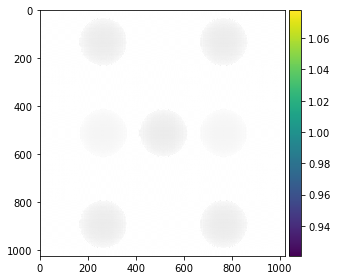

In [66]:
imshow(np.squeeze(x_train[0]))
plt.show

In [67]:
model = sm.Unet(BACKBONE, encoder_weights='imagenet',input_shape=(1024, 1024, 3))
model.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 1024, 1024, 3 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalizationV1)  (None, 1024, 1024, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_238 (ZeroPadding (None, 1030, 1030, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 512, 512, 64) 9408        zero_padding2d_238[0][0]         
__________________________________________________________________________________________________
bn0 (Batch

In [68]:
y_train.shape

(80, 1024, 1024, 1)

In [69]:
model.fit(
   x=x_train,
   y=y_train,
   batch_size=16,
   epochs=3,
   validation_data=(x_val, y_val),
)
model.save(os.path.join("models", "sm_resnet34_3epochs"))

Train on 80 samples, validate on 10 samples
Epoch 1/3
80/80 [==============================] - 1127s 14s/sample - loss: 0.9818 - iou_score: 0.5936 - val_loss: 16.8368 - val_iou_score: 8.7878e-04
Epoch 2/3
80/80 [==============================] - 1101s 14s/sample - loss: 0.6053 - iou_score: 0.7335 - val_loss: 16.8494 - val_iou_score: 0.0016
Epoch 3/3
80/80 [==============================] - 1095s 14s/sample - loss: 0.4121 - iou_score: 0.8111 - val_loss: 16.8633 - val_iou_score: 0.0042


In [56]:
print(X_data.shape)
print(Y_data.shape)

(100, 1024, 1024, 1)
(100, 1024, 1024, 1)


In [59]:
print(np.amax(X_data))
print(np.amin(X_data))

1.0778287649154663
0.9167473316192627


In [60]:
print(np.amax(Y_data))
print(np.amin(Y_data))

1.0
0.9252259731292725


In [93]:
X_data = np.subtract(X_data,0.95)
X_data = np.multiply(X_data,10)

In [94]:
Y_data = np.subtract(Y_data,0.95)
Y_data = np.multiply(Y_data,10)

In [90]:
print(np.amax(X_data))
print(np.amin(X_data))

0.7782876491546631
-0.832526683807373


In [98]:
print(np.amax(Y_data))
print(np.amin(Y_data))

0.5000000000000004
-0.24774026870727495


<function matplotlib.pyplot.show(*args, **kw)>

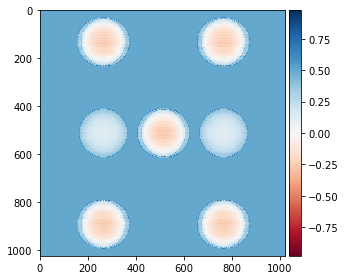

In [95]:
imshow(np.squeeze(X_data[2]))
plt.show

In [97]:
print(np.sum(Y_data))
print(100*1024*1024)

42923166.220345505
104857600


<function matplotlib.pyplot.show(*args, **kw)>

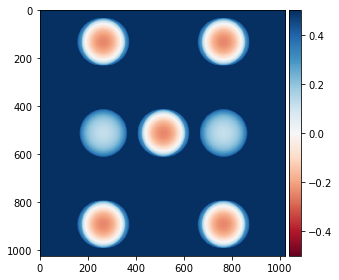

In [96]:
imshow(np.squeeze(Y_data[2]))
plt.show

In [28]:
def root_mean_squared_error(y_true, y_pred):
    return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))

In [29]:
IMG_WIDTH = 1024
IMG_HEIGHT = 1024
IMG_CHANNELS = 1


#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

#Expansive path
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c3)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer=Adam(lr = 1e-4), loss=root_mean_squared_error, metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1024, 1024, 1 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1024, 1024, 1 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 1024, 1024, 1 160         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)    

-0.99997


In [99]:
#Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

In [100]:
results = model.fit(X_data, Y_data, validation_split=0.1, batch_size=16, epochs=10, callbacks=callbacks)
model.save(os.path.join("models", "narrow_unet_10epochs_MSE_0.001lr_negativedata"))

Train on 90 samples, validate on 10 samples
Epoch 1/10
90/90 [==============================] - 521s 6s/sample - loss: 0.1862 - acc: 0.0000e+00 - val_loss: 0.2070 - val_acc: 0.0000e+00
Epoch 2/10
90/90 [==============================] - 521s 6s/sample - loss: 0.1863 - acc: 0.0000e+00 - val_loss: 0.2069 - val_acc: 0.0000e+00
Epoch 3/10
90/90 [==============================] - 504s 6s/sample - loss: 0.1862 - acc: 0.0000e+00 - val_loss: 0.2066 - val_acc: 0.0000e+00
Epoch 4/10
90/90 [==============================] - 494s 5s/sample - loss: 0.1859 - acc: 0.0000e+00 - val_loss: 0.2064 - val_acc: 0.0000e+00
Epoch 5/10
90/90 [==============================] - 496s 6s/sample - loss: 0.1856 - acc: 0.0000e+00 - val_loss: 0.2061 - val_acc: 0.0000e+00
Epoch 6/10
90/90 [==============================] - 489s 5s/sample - loss: 0.1853 - acc: 0.0000e+00 - val_loss: 0.2059 - val_acc: 0.0000e+00
Epoch 7/10
90/90 [==============================] - 491s 5s/sample - loss: 0.1851 - acc: 0.0000e+00 - val_loss

In [74]:
X_test = np.array([graytorgb(gray) for gray in X_test]) 

In [75]:
predict_test = model.predict(
    X_test, batch_size=None, verbose=1, steps=None, max_queue_size=10,
    workers=1, use_multiprocessing=False
)

10/10 [==============================] - 30s 3s/sample


In [76]:
predict_test.shape
print(np.sum(predict_test[:,:,:]))
print(1024*1024*10)

43996.676
10485760


<function matplotlib.pyplot.show(*args, **kw)>

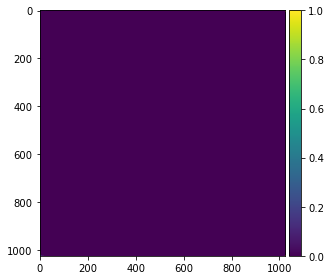

In [80]:
imshow(np.squeeze(predict_test[2]))
plt.show